# Binary Classification Model - No Augmentation

In order to begin the process of building the solution, lets start building a simple convolutional neural network to try classifying the leafs as well as trying to understand the complexity of the task at hand.


> Drive with files: https://drive.google.com/drive/folders/1l_thkTxtzfkN6Nifjilnvb3909TIX8QH?usp=share_link

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL_HW1

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns



# IMPORTING THE FILTERED DATA WITHOUT THE IMPUTED NOISE
images = np.load('clean_images.npy', allow_pickle=True)  #shape (5004,96,96,3)
labels = np.load('clean_labels.npy', allow_pickle=True)  #shape (5004,)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1R5jUyJ3mbT3yTPzPeKQilqan5pgW_sus/HW1
2.14.0


## Data Preparation

In order to avoid data leakage, lets split the dataset now. Lets set 500 samples for validation, 500 for test and the rest we'll use for training. Let's not forget to split the data in a stratified manner, given that there's a clear dataset imbalance.

In [ ]:
X = images.copy()
y = labels.copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=500,
                                                            random_state=42, stratify=y)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (4504, 96, 96, 3)
Training-Validation Label Shape: (4504,)
Test Data Shape: (500, 96, 96, 3)
Test Label Shape: (500,)


In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=500, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (4004, 96, 96, 3)
Training Label Shape: (4004,)
Validation Data Shape: (500, 96, 96, 3)
Validation Label Shape: (500,)


Let's normalize, all data so that it helps to keep a single global learning rate for the batch and avoid different magnitudes of values running on the network.

In [ ]:
import tensorflow as tf
X_test = tf.cast(X_test/255.0, tf.float32)
X_val = tf.cast(X_val/255.0, tf.float32)
X_train = tf.cast(X_train/255.0, tf.float32)

## Model Creation

The first proposed model to understand the process of neural network creation consisted on applying a sequence of Convolutional Layers in sequence with a constant number of channels. In order to try to extract the main features os the images.

With some tests and hyperparameter tests, it was possible to see that a network with this amount of parameters was leading to a overfitting. To avoid this, it was added a few layers of droppout in order to reduce variance by "ensembling" the network.

In [ ]:
model = tfk.models.Sequential()

model.add(tfkl.Conv2D(128, (3, 3),input_shape=(96,96,3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(128, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(128, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(128, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(64, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Flatten())

model.add(tfkl.Dense(512, activation='relu'))
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Dense(128, activation='relu'))
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Dense(64, activation='relu'))
model.add(tfkl.BatchNormalization())

# just one layer at the end with sigmoid, not softmax
model.add(tfkl.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tfk.optimizers.Adam(), metrics=['accuracy'], loss = tfk.losses.BinaryCrossentropy())

# patience was set during development with the objective of avoiding useless training by the
calls = tfk.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 128)       0

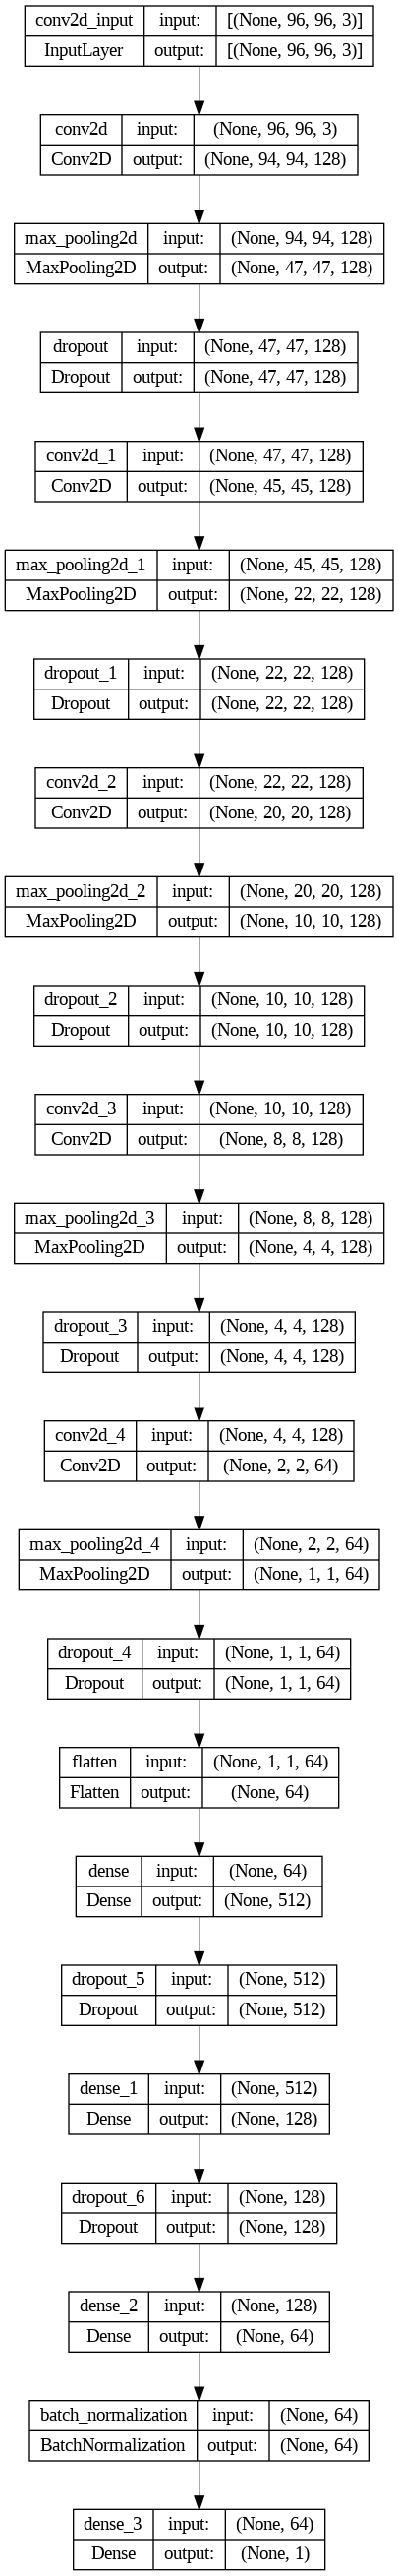

In [ ]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# the batch size was changed a couple of times in order to explore the convergence x computation trade off

batch_size = 128
epochs = 200

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [calls]
).history

Epoch 1/200
32/32 [==============================] - 308s 10s/step - loss: 0.6970 - accuracy: 0.5649 - val_loss: 0.6679 - val_accuracy: 0.6200
Epoch 2/200
32/32 [==============================] - 306s 10s/step - loss: 0.6688 - accuracy: 0.6196 - val_loss: 0.6643 - val_accuracy: 0.6200
Epoch 3/200
32/32 [==============================] - 301s 9s/step - loss: 0.6615 - accuracy: 0.6214 - val_loss: 0.6639 - val_accuracy: 0.6200
Epoch 4/200
24/32 [=====================>........] - ETA: 1:13 - loss: 0.6538 - accuracy: 0.6243

In [ ]:
# saving the model created
model.save('Sequential')

This code is just the plotting code taken from the lab sessions

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Load model
model = tfk.models.load_model('Sequential')

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (500, 1)


Accuracy: 0.778
Precision: 0.7232
Recall: 0.6737
F1: 0.6975


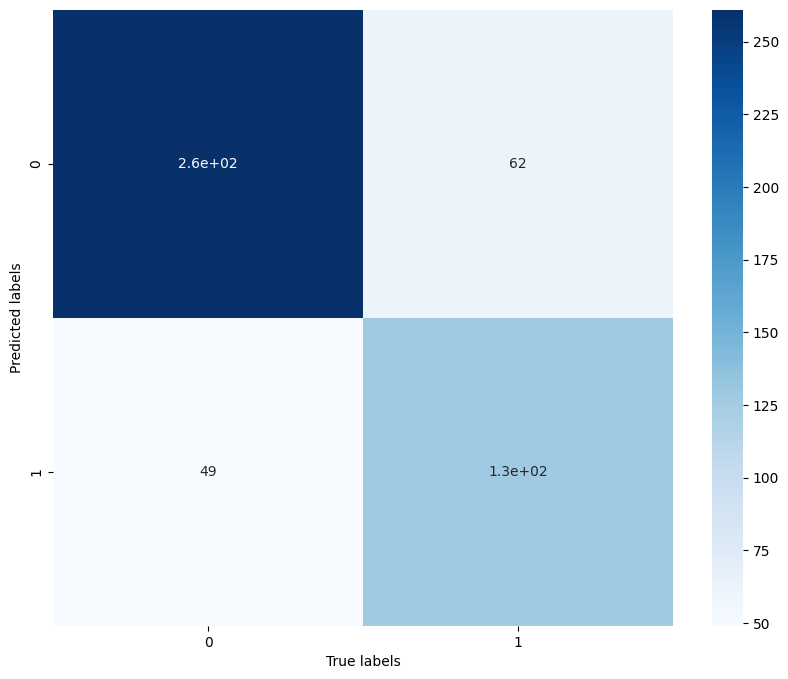

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions.round())

# Compute classification metrics
accuracy = accuracy_score(y_test, predictions.round())
precision = precision_score(y_test, predictions.round())
recall = recall_score(y_test, predictions.round())
f1 = f1_score(y_test, predictions.round())

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Conclusions

As we can see, the model indeed has learned something regarding the patters from the process, however, it still strugles on obtaining a deeper understanding of the patters while overfitts the data. Given that, on the next notebook, we need to explore a new model applying data augmentation, so that we can obtain a better performance on different generated images. Which could allows to create more complex models without overfitting.